# Exercise 3: Mode choice classification

Transportation mode choice is a critical decision-making process that individuals, businesses, and urban planners face daily. It involves selecting the most suitable mode of transportation for a given journey/trip, taking into account factors such as cost, time, convenience, and environmental impact. In this tutorial, we will explore how to address the mode choice problem using classification models.

**Key points to cover:**

* Mode choice problem;
* *Encoding techniques* for categorical variables
* Classification models *implementation*
* Classification models *evaluation metrics*


In [2]:
import pandas as pd
from statistics import mode
import numpy as np
import os

## Loading the dataset

In [3]:
# The path of the dataset
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_3_Mode_choice_model/modeChoiceData.csv'
# Load the data use the pandas
moide_choice_data = pd.read_csv(url)

## Data Preparation

Transform the dataset into a binary classification problem: car vs. rail.

In [4]:
mode_choice_car_df = (
    moide_choice_data.loc[moide_choice_data["choice"].isin(["car", "rail"]),
     ["time_car", "cost_car", "time_rail", "cost_rail", "access_rail", "service_rail", "choice"]]
    .reset_index()
    .drop(columns=["index"])
)

Check the distribution of the classes:

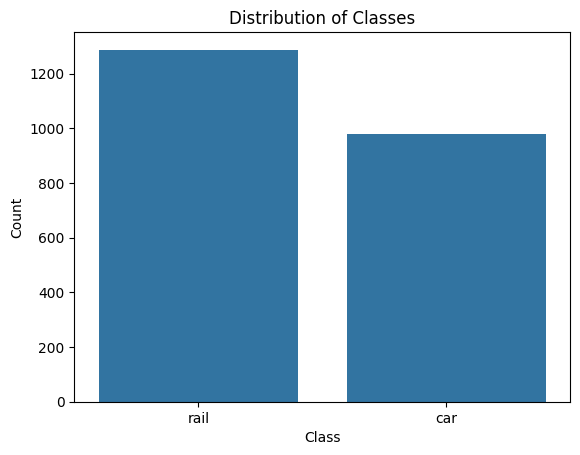

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the classes are stored in a column called 'class'
sns.countplot(data=mode_choice_car_df, x='choice')

# Add title and labels
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Show the plot
plt.show()

In [6]:
mode_choice_car_df.head(10)

,time_car,cost_car,time_rail,cost_rail,access_rail,service_rail,choice
0,275,45,170,55,25,food,rail
1,275,45,155,35,5,no-frills,rail
2,300,45,155,65,20,no-frills,rail
3,390,35,155,65,15,food,rail
4,275,40,155,55,5,food,rail
5,250,50,120,65,20,wifi,rail
6,275,30,155,65,25,wifi,car
7,300,45,170,45,5,no-frills,rail
8,345,30,140,65,15,no-frills,car
9,250,40,140,75,20,wifi,car


Get to know the different values for the categorical variable *service rail*.

In [7]:
mode_choice_car_df.service_rail.unique()

array(['food', 'no-frills', 'wifi'], dtype=object)

Get an overview about the statistics of the numerical columns:

In [8]:
mode_choice_car_df.describe()

,time_car,cost_car,time_rail,cost_rail,access_rail
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000
mean,310.505296,40.083848,143.175199,53.415711,15.037511
std,49.424710,6.988924,18.236603,14.285212,7.127716
min,250.000000,30.000000,120.000000,35.000000,5.000000
25%,275.000000,35.000000,130.000000,45.000000,10.000000
50%,300.000000,40.000000,140.000000,55.000000,15.000000
75%,345.000000,45.000000,155.000000,65.000000,20.000000
max,390.000000,50.000000,170.000000,75.000000,25.000000


### Train-Test Split

We divide the data first into its explaining variables/features (X) and the variable that we want to predict/target (y).

Afterwards we create a train and test set with a 80%/20% split.

In [9]:
from sklearn.model_selection import train_test_split

X = mode_choice_car_df.drop(columns=["choice"])
y = mode_choice_car_df["choice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
X_train.head()

,time_car,cost_car,time_rail,cost_rail,access_rail,service_rail
1150,250,45,170,35,15,food
1538,275,35,140,65,20,food
1254,300,40,140,55,25,food
1843,345,45,130,45,10,no-frills
977,345,35,140,45,25,food


### Scaling and Encoding the features

We remember: especially for distance calculations we need to scale the features to ensure equal influence.

Furthermore, we have a categorical variable in our dataset: *service_rail*. We need to treat this variable by an encoding technique before using it. In this case we have decided for one-hot encoding.


In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = ["service_rail"]
columns_to_scale  = ["time_car", "cost_car", "time_rail", "cost_rail", "access_rail"]

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
X_train_scaled_columns  = scaler.fit_transform(X_train[columns_to_scale])
X_train_encoded_columns = ohe.fit_transform(X_train[columns_to_encode])

X_test_scaled_columns  = scaler.fit_transform(X_test[columns_to_scale])
X_test_encoded_columns = ohe.fit_transform(X_test[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_train_processed = np.concatenate([X_train_scaled_columns, X_train_encoded_columns], axis=1)
X_test_processed = np.concatenate([X_test_scaled_columns, X_test_encoded_columns], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Task 1: Build your own KNN classifier

Your task is now to implement the KNN algorithm yourself. Return the classification of the unclassified point (*X_unclassified*).

Python methods that might be helpful:
- **for-loop**: ```for value in mylist:```
- **Append values to a list:** ```my_list.append(value)```
- **Get the indices of the n smallest values of the list mylist**: ```np.argsort(my_list)[:n]```
- **Gets the values from a pandas series at the location of the given indices**: ```y_train.iloc[indices]```
- **Get the most frequent element in a list**: ```mode(mylist)```

### Implement Distance Function

The euclidean distance function allows to determine the distance between two points.

In [12]:
def euclidean_distance(point1, point2):
  # go through the features of point1 and 2
  current_sum = 0
  for i in range(0, len(point1)):
    # calculate their squared difference and sum it
    current_sum += (point1[i]-point2[i])**2

  # calculate the square root from the summed distances
  distance = np.sqrt(current_sum)

  return distance

### Code of your own KNN classifier:

In [13]:
def custom_knn(X_train, y_train, X_unclassified, k):

  #################################################
  # Your code                                     #
  #################################################

  # change that to the actual classification
  classification = None
  return classification

### Make a prediction

In [ ]:
custom_knn(X_train_processed, y_train, X_test_processed[0], 5)

### Compare with the true class

In [ ]:
y_test.iloc[0]

## Task 2: Understand Classification Evaluation Metrics

 - **Accuracy**: The ratio of correctly predicted instances to the total instances.
   - Formula: `Accuracy = (TP + TN) / (TP + TN + FP + FN)`

 - **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.
   - Formula: `Precision = TP / (TP + FP)`

 - **Recall (Sensitivity/True Positive Rate)**: The ratio of correctly predicted positive observations to all observations in the actual class.
   - Formula: `Recall = TP / (TP + FN)`

 - **F1-Score**: The harmonic mean of precision and recall.
   - Formula: `F1-Score = 2 * (Precision * Recall) / (Precision + Recall)`

Let's calculate these metrics using an example scenario.

**Scenario:**
- Imagine you are building a model to predict mode choice with a dataset where only 1% of the observations used the mode car (i.e., imbalanced data).
- Assume you have 10,000 observations, where 100 are mode car (positive class) and 9,900 are mode rail (negative class).

### Task 2.1: Initial Model Evaluation
Consider a model that predicts all transactions as rail (negative class).

- a) Calculate the following metrics: Accuracy, Precision, Recall, F1-Score
- b) What can you observe? Are all measures equally suitable for this task?


## Task 3: ROC Curve

In this task the goal is to understand the ROC curve and how it can be used to identify the optimal threshold for a classification task with logistic regression.

### Fit Logistic Regression Model
First we are fitting a logistic regression model. The model internally predicts a probability, e.g., for the mode choice being car in our example.

It is important to find the optimal threshold where we "trust" the model.

Is 50% probability enough that we assign the label "car" to an observation? Or is maybe a threshold of 70% necessary to get a good result?

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y_train = y_train.map({'car': 1, 'rail': 0})
y_test = y_test.map({'car': 1, 'rail': 0})

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_processed, y_train)

LogisticRegression()

### Task 3.1: Interpret the ROC Curve

One way to find the optimal parameter set for such a model in a binary classification setting is the Receiver Operating Characteristic (ROC) curve (see below).

Now try to interprete with the lecture slides what this curve means and what information we can derive from it.

- a) How would the optimal ROC curve look like?
- b) How does the ROC curve supports us in finding the optimal threshold parameter?
- c) Find the approximate FPR and TPR of the optimal threshold given the ROC curve below.

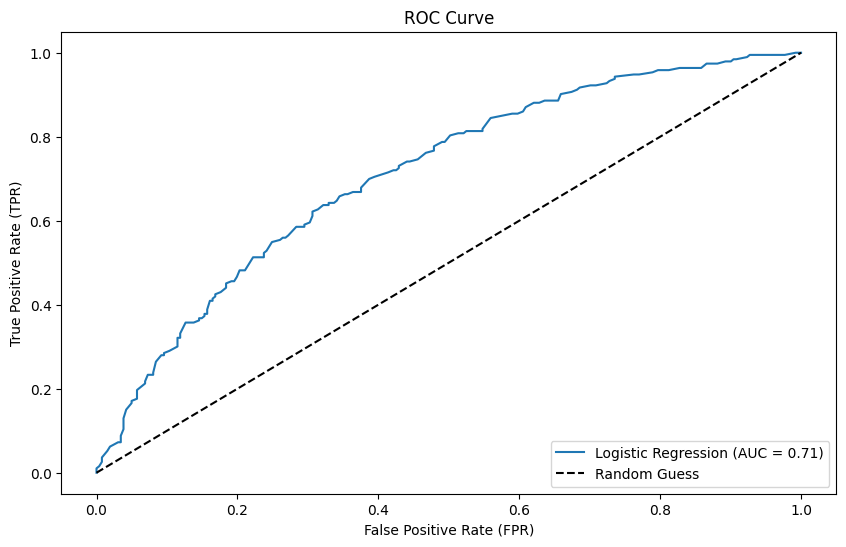

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the test set
y_probs = model.predict_proba(X_test_processed)[:, 1]

# ## Part 2: Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Determine the best threshold parameter

In [24]:
# calculate the distance to the top-left corner (0, 1) for each threshold
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)

# find the index of the smallest distance
optimal_index = np.argmin(distances)

# get the optimal threshold
optimal_threshold = thresholds[optimal_index]
optimal_threshold

0.4675013198257838

### Find the TPR, FPR of this threshold

In [27]:
# print(fpr[optimal_index])
# print(tpr[optimal_index])